# Problem Statement

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

- Demographics (city, age, gender etc.)
- Tenure information (joining date, Last Date)
- Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

## Column Profiling:

- MMMM-YY : Reporting Date (Monthly)
- Driver_ID : Unique id for drivers
- Age : Age of the driver
- Gender : Gender of the driver – Male : 0, Female: 1
- City : City Code of the driver
- Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
- Income : Monthly average Income of the driver
- Date Of Joining : Joining date for the driver
- LastWorkingDate : Last date of working for the driver
- Joining Designation : Designation of the driver at the time of joining
- Grade : Grade of the driver at the time of reporting
- Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
- Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

In [1]:
# Importing the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score,roc_auc_score,auc
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from imblearn.over_sampling import SMOTE
import pickle

In [2]:
pip install --upgrade numpy

  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/97/43/4cd9dc8c051537ed0613fcfc4229dfb9eb39fe058c8d42632977465bfdb5/numpy-1.26.0-cp39-cp39-win_amd64.whl.metadata
  Using cached numpy-1.26.0-cp39-cp39-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.0-cp39-cp39-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\bagal\\anaconda3\\Lib\\site-packages\\numpy\\~libs\\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



## Importing Dataset and Data Preprocessing

In [3]:
# Importing the dataset.

df=pd.read_csv('ola_data.csv', index_col='Unnamed: 0')

display(df.head(5))

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [4]:
# Checking the shape of the given dataset

df.shape

(19104, 13)

In [5]:
# Checking for percentage of missing values

np.round(df.isna().mean().sort_values(ascending=False)*100,2)

LastWorkingDate         91.54
Age                      0.32
Gender                   0.27
MMM-YY                   0.00
Driver_ID                0.00
City                     0.00
Education_Level          0.00
Income                   0.00
Dateofjoining            0.00
Joining Designation      0.00
Grade                    0.00
Total Business Value     0.00
Quarterly Rating         0.00
dtype: float64

In [6]:
# Checking the data_type of each of the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 2.0+ MB


In [7]:
# Checking for duplicate observations.

df.duplicated().sum()

0

### Preliminary Observations
- There are a few missing values in columns - "Age" and "Gender". We will take care of these missing values later. 
- There are a lot of missing values in column - "LastWorkingDate". From this column, we can get our target variable. The drivers who have churned would have a **non-null LastWorkingDate.**
- "MMM-YY", "Dateofjoining" and "LastWorkingDate" columns are in object data type. We need to change to date_type format.
- There are no duplicate observations.
- The report is generated on the 1st of every month.
- Need to encode City feature later.

In [8]:
# Changing data type to date_time format of columns - "MMM-YY", "Dateofjoining" and "LastWorkingDate".

df[['MMM-YY','Dateofjoining','LastWorkingDate']] = df[['MMM-YY','Dateofjoining','LastWorkingDate']].astype('datetime64')

### Aggregate Dataframe 
Creating Another DataFrame to store Aggregate Level Information for each driver

In [9]:
dataset = pd.DataFrame(data=df['Driver_ID'].unique(),columns=['Driver_ID'])

print(dataset.shape) #There are total 2381 drivers.

(2381, 1)


In [10]:
# Getting the list of drivers who have churned and who have not_churned

churned_drivers = set(df.loc[~df['LastWorkingDate'].isna(),'Driver_ID'])
not_churned_drivers = set(df['Driver_ID']).difference(churned_drivers)

### Getting the Target Column - "Churn"

In [11]:
# 1 : Churned
# 0 : Not Churned

dataset['Churn'] = dataset['Driver_ID'].apply(lambda x : 1 if x in churned_drivers else 0)

# Lets check the value count of the 2 categories.
dataset['Churn'].value_counts()

1    1616
0     765
Name: Churn, dtype: int64

### Getting Values of Features for Aggregate Dataset

In [12]:
# Sorting the data on the basis of "Driver_ID" and "MMM-YY".

df.sort_values(by=['Driver_ID','MMM-YY'],inplace=True)

#### 1) City

In [13]:
# Lets do a quick check if there there are multiple cities assigned to any driver.

df.groupby(by='Driver_ID').nunique()['City'].value_counts()

# We observe that all drivers have only 1 city mapped against them.

1    2381
Name: City, dtype: int64

In [14]:
# Getting the respective city for each driver and storing in aggregated dataset.

temp = df.groupby('Driver_ID').max()[['City']]
dataset = pd.merge(left=dataset,right=temp,on='Driver_ID')

#### 2) Education_Level

In [15]:
# Lets do a quick check if there there are multiple Education_Level assigned to any driver.

df.groupby(by='Driver_ID').nunique()['Education_Level'].value_counts()

# We observe that all drivers have only 1 Education_Level mapped against them.

1    2381
Name: Education_Level, dtype: int64

In [16]:
# Getting the respective Education_Level for each driver and storing in aggregated dataset.

temp = df.groupby('Driver_ID').max()[['Education_Level']]
dataset = pd.merge(left=dataset,right=temp,on='Driver_ID')

#### 3) Income

In [17]:
# We can get the last salary for each driver and store in aggregated dataset.

temp = df.groupby('Driver_ID').last()[['Income']]
dataset = pd.merge(left=dataset,right=temp,on='Driver_ID')

#### 4) Age

In [18]:
# We can get the maximum Age for each driver and store in aggregated dataset.

temp = df.groupby('Driver_ID').max()[['Age']]
dataset = pd.merge(left=dataset,right=temp,on='Driver_ID')

#### 5) Gender

In [19]:
# Lets do a quick check if there there are multiple Gender assigned to any driver.

df.groupby(by='Driver_ID').nunique()['Gender'].value_counts()

# We observe that all drivers have only 1 Gender mapped against them.

1    2381
Name: Gender, dtype: int64

In [20]:
# Getting the respective Gender for each driver and storing in aggregated dataset.

temp = df.groupby('Driver_ID').max()[['Gender']]
dataset = pd.merge(left=dataset,right=temp,on='Driver_ID')

#### 6) Joining_Designation

In [21]:
# Lets do a quick check if there there are multiple Joining Designation assigned to any driver.

df.groupby(by='Driver_ID').nunique()['Joining Designation'].value_counts()

# We observe that all drivers have only 1 Joining Designation mapped against them.

1    2381
Name: Joining Designation, dtype: int64

In [22]:
# Getting the respective Joining Designation for each driver and storing in aggregated dataset.

temp = df.groupby('Driver_ID').max()[['Joining Designation']]
dataset = pd.merge(left=dataset,right=temp,on='Driver_ID')

#### 7) Grade

In [23]:
# We can get the last Grade for each driver and store in aggregated dataset.

temp = df.groupby('Driver_ID').last()[['Grade']]
dataset = pd.merge(left=dataset,right=temp,on='Driver_ID')

#### 8) Total Business Value

In [24]:
# We can get the total sum of Total Business Value for each driver and store in aggregated dataset.

temp = df.groupby('Driver_ID')[['Total Business Value']].sum()
dataset = pd.merge(left=dataset,right=temp,on='Driver_ID')

#### 9) Quarterly Rating

In [25]:
# We can get the last Quarterly Rating for each driver and store in aggregated dataset.

temp = df.groupby('Driver_ID').last()[['Quarterly Rating']]
dataset = pd.merge(left=dataset,right=temp,on='Driver_ID')

## Feature Engineering

### 1) Income_Flag

- If the income has increased for a particular driver, then we can flag him as 1, or else 0.
- To achieve this, we can compare the first month income and last month income for every driver.

In [26]:
# Getting the first and last month income for each driver.

first_inc = df.groupby('Driver_ID').first()[['Income']]
last_inc = df.groupby('Driver_ID').last()[['Income']]

# Now lets compare the first and last month income for every driver and create the flag feature.
temp = (last_inc > first_inc).astype('int64').reset_index().rename(columns={'Income' : 'Inc_Flag'})

# Storing Income Flag in aggregated dataset.
dataset=pd.merge(left=dataset,right=temp,on='Driver_ID')

### 2) Quarterly_Rating_Flag
- If the Quarterly_Rating has increased for a particular driver, then we can flag him as 1, or else 0.
- To achieve this, we can compare the first month Quarterly_Rating and last month Quarterly_Rating for every driver.

In [27]:
# Getting the first and last month Quarterly_Rating for each driver.

first_qr = df.groupby('Driver_ID').first()[['Quarterly Rating']]
last_qr = df.groupby('Driver_ID').last()[['Quarterly Rating']]

# Now lets compare the first and last month Quarterly_Rating for every driver and create the flag feature.
temp = (last_qr > first_qr).astype('int64').reset_index().rename(columns={'Quarterly Rating' : 'QR_Flag'})

# Storing Quarterly_Rating_Flag in aggregated dataset.
dataset=pd.merge(left=dataset,right=temp,on='Driver_ID')

### 3) Duration

We can get The Duration for which each driver had Been driving vehicle for Ola.
- For drivers who have churned, we can get the difference in no of days between DateOfJoining and LastWorkingDate.
- For drivers who have not churned, we can get the difference in no of days between DateOfJoining and the Last_Monthly_Report_Date.

In [28]:
# Lets do a quick check if there there are multiple Date_Of_Joining assigned to any driver.

display(df.groupby(by='Driver_ID').nunique()['Dateofjoining'].value_counts())

# We observe that all drivers have only 1 Date_Of_Joining mapped against them.

# Getting the respective Date_Of_Joining for each driver and storing in aggregated dataset.

temp = df.groupby('Driver_ID').max()[['Dateofjoining']]
dataset=pd.merge(left=dataset,right=temp,on='Driver_ID')

1    2381
Name: Dateofjoining, dtype: int64

In [29]:
# Finding out the last_working_date for churned_drivers, and last_month_report_date for not_churned_drivers.

last_work_dates = df[df['Driver_ID'].isin(churned_drivers)].groupby(by='Driver_ID').max()['LastWorkingDate']
last_month_dates = df[df['Driver_ID'].isin(not_churned_drivers)].groupby(by='Driver_ID').max()['MMM-YY']

In [30]:
# Lets check if the last_month_report_date for all not_churned_drivers is the same.

display(last_month_dates.value_counts())

# This is strange. The last date should be the same for all drivers who have not churned. It should be "2020-12-01".
# Perhaps these drivers are on a break, or there could be errors in the dataset. Lets remove these drivers from our dataset.

erroneous_dates = last_month_dates.value_counts()[1:].index

# Getting the list of these driver_ids.
driver_ids_to_remove = last_month_dates[last_month_dates.isin(erroneous_dates)].index

# Removing these drivers.
dataset = dataset[~dataset['Driver_ID'].isin(driver_ids_to_remove)].reset_index(drop=True)

2020-12-01    741
2020-02-01      6
2020-05-01      6
2019-12-01      4
2020-01-01      3
2020-03-01      2
2020-06-01      2
2019-09-01      1
Name: MMM-YY, dtype: int64

In [31]:
# Combining columns "LastWorkingDate" and "MMM-YY" into 1 column named "Last_Date" and storing in aggregated dataset.

dataset = pd.merge(left=dataset,right=last_work_dates.reset_index(),on='Driver_ID',how='left')
dataset.loc[dataset['Churn']==0,'LastWorkingDate'] = pd.to_datetime("2020-12-01",format="%Y/%m/%d")
dataset.rename(columns={'LastWorkingDate':'Last_Date'}, inplace=True)

# Calculating the total duration of driving for each driver in days.
dataset['Duration'] = (dataset['Last_Date'] - dataset['Dateofjoining']).dt.days

## Aggregated Dataset 

In [32]:
# We have our aggregated dataset, which can be used for EDA.

dataset.head()

,Driver_ID,Churn,City,Education_Level,Income,Age,Gender,Joining Designation,Grade,Total Business Value,Quarterly Rating,Inc_Flag,QR_Flag,Dateofjoining,Last_Date,Duration
0,1,1,C23,2,57387,28.0,0.0,1,1,1715580,2,0,0,2018-12-24,2019-03-11,77
1,2,0,C7,2,67016,31.0,0.0,2,2,0,1,0,0,2020-11-06,2020-12-01,25
2,4,1,C13,2,65603,43.0,0.0,2,2,350000,1,0,0,2019-12-07,2020-04-27,142
3,5,1,C9,0,46368,29.0,0.0,1,1,120360,1,0,0,2019-01-09,2019-03-07,57
4,6,0,C11,1,78728,31.0,1.0,3,3,1265000,2,0,1,2020-07-31,2020-12-01,123


In [33]:
# Checking the shape of the dataset
print('Shape:',dataset.shape)

#Checking for duplicate values.
print('Duplicate Observations:',len(dataset[dataset.duplicated()]))

Shape: (2357, 16)
Duplicate Observations: 0


In [34]:
# Check for NULL values

dataset.isna().sum()

Driver_ID               0
Churn                   0
City                    0
Education_Level         0
Income                  0
Age                     0
Gender                  0
Joining Designation     0
Grade                   0
Total Business Value    0
Quarterly Rating        0
Inc_Flag                0
QR_Flag                 0
Dateofjoining           0
Last_Date               0
Duration                0
dtype: int64

In [35]:
# Checking the Data Types of the columns

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2357 entries, 0 to 2356
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Driver_ID             2357 non-null   int64         
 1   Churn                 2357 non-null   int64         
 2   City                  2357 non-null   object        
 3   Education_Level       2357 non-null   int64         
 4   Income                2357 non-null   int64         
 5   Age                   2357 non-null   float64       
 6   Gender                2357 non-null   float64       
 7   Joining Designation   2357 non-null   int64         
 8   Grade                 2357 non-null   int64         
 9   Total Business Value  2357 non-null   int64         
 10  Quarterly Rating      2357 non-null   int64         
 11  Inc_Flag              2357 non-null   int64         
 12  QR_Flag               2357 non-null   int64         
 13  Dateofjoining     

## Categorical and Continuous Features

In [36]:
# Getting the number of unique values for each variable.

data_types=[]
categories=[]

for column in dataset.columns:
    categories.append(dataset[column].nunique())
    data_types.append(dataset[column].dtype)

display(pd.DataFrame(data=[categories,data_types],index=['Categories','Data_Type'],columns=dataset.columns).T)

,Categories,Data_Type
Driver_ID,2357,int64
Churn,2,int64
City,29,object
Education_Level,3,int64
Income,2316,int64
Age,36,float64
Gender,2,float64
Joining Designation,5,int64
Grade,5,int64
Total Business Value,1617,int64


In [37]:
# Segregating into Continuous and Categorical variables.

continuous=['Income','Age','Total Business Value','Duration']
categorical=['City','Education_Level','Gender','Joining Designation','Grade','Quarterly Rating','Inc_Flag','QR_Flag']

## Descriptive Statistics

In [38]:
# Continuous Variables.

np.round(dataset[continuous].describe())

# "Duration" cannot be negative. Need to inspect further.
# Atleast 25 percent Drivers have "Total Business Value" less than or equal to 0. These could be new drivers.

,Income,Age,Total Business Value,Duration
count,2357.0,2357.0,2357.0,2357.0
mean,59260.0,34.0,4610845.0,425.0
std,28305.0,6.0,9162408.0,565.0
min,10747.0,21.0,-1385530.0,-27.0
25%,39119.0,29.0,0.0,92.0
50%,55285.0,33.0,834440.0,182.0
75%,75765.0,37.0,4173650.0,467.0
max,188418.0,58.0,95331060.0,2801.0


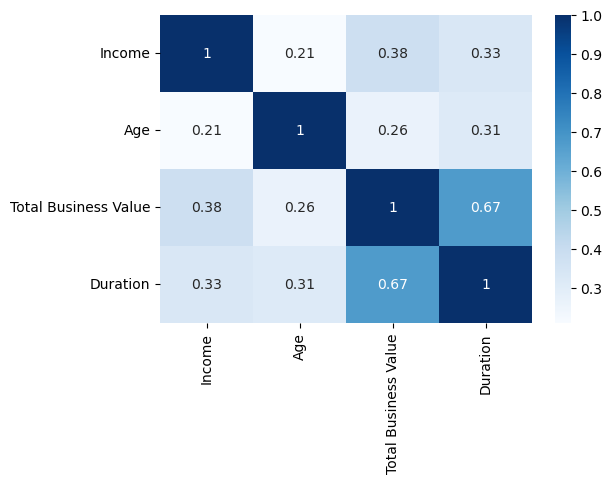

In [39]:
# Correlation Coefficient of Continuous Variables.

plt.figure(figsize=(6,4))
sns.heatmap(dataset[continuous].corr(),annot=True,cmap='Blues')
plt.show()

# There is strong correlation between "Duration" and "Total_Business_Value".

C:\Users\bagal\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


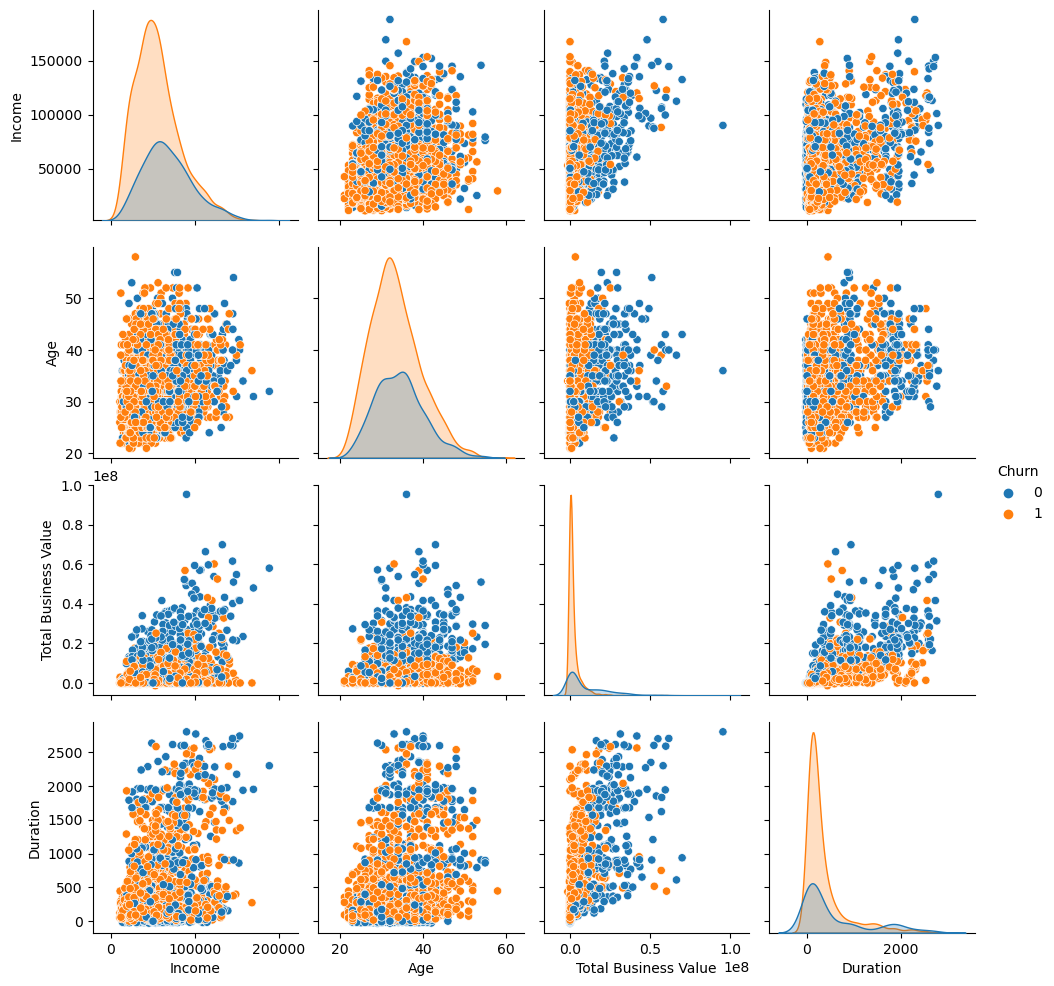

In [40]:
# Scatter Plot of Continuous Features.

sns.pairplot(data=dataset,vars=continuous,hue='Churn')
plt.show()

In [41]:
# Categorical Variables.

dataset[categorical].astype('category').describe()

,City,Education_Level,Gender,Joining Designation,Grade,Quarterly Rating,Inc_Flag,QR_Flag
count,2357,2357,2357.0,2357,2357,2357,2357,2357
unique,29,3,2.0,5,5,4,2,2
top,C20,2,0.0,1,2,1,0,0
freq,152,793,1388.0,1019,848,1721,2314,2000


## Exploratory Data Analysis

### 1) Churn

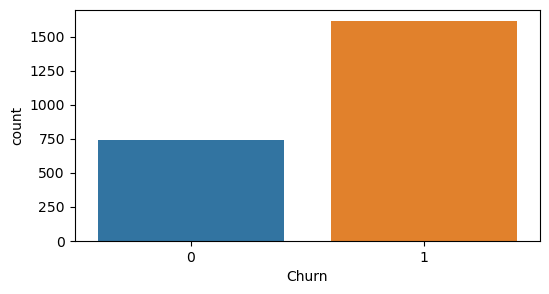

1    69.0
0    31.0
Name: Churn, dtype: float64

In [42]:
# Lets look at the distribution of "Churn"

plt.figure(figsize=(6,3))
sns.countplot(data=dataset,x='Churn')
plt.show()

np.round(dataset['Churn'].value_counts(normalize=True)*100)

# We have imbalanced data. Need to balance the data before building the model.

### 2) Duration

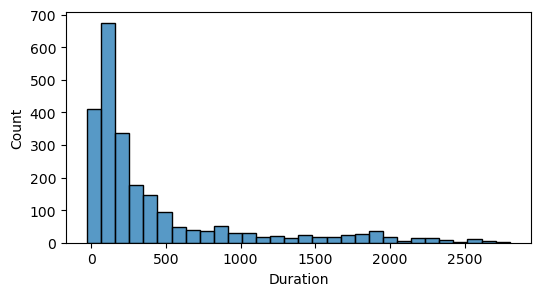

,count,mean,std,min,25%,50%,75%,max
Duration,2357.0,425.196012,564.592189,-27.0,92.0,182.0,467.0,2801.0


In [43]:
# Lets look at the distribution of "Duration".

plt.figure(figsize=(6,3))
sns.histplot(data=dataset,x='Duration',bins=30)
plt.show()

#Lets check the range of "Duration" feature.

dataset[['Duration']].describe().T

# The distribution is highly right skewed. 
# Duration has negative values, which is not possible. Need to inspect further.

In [44]:
# Getting few records for driver-ids for whom we have negative Duration.

display(dataset.loc[dataset['Duration']<0,['Dateofjoining','Last_Date','Duration']].head())

# We observe that "Dateofjoining" is after "Last_Date" which is not possible. 
# These could be data entry errors. We can remove these drivers.

dataset = dataset[dataset['Duration']>=0].reset_index(drop=True)

,Dateofjoining,Last_Date,Duration
6,2020-12-07,2020-12-01,-6
124,2020-12-11,2020-12-01,-10
175,2020-12-20,2020-12-01,-19
228,2020-12-20,2020-12-01,-19
240,2020-12-18,2020-12-01,-17


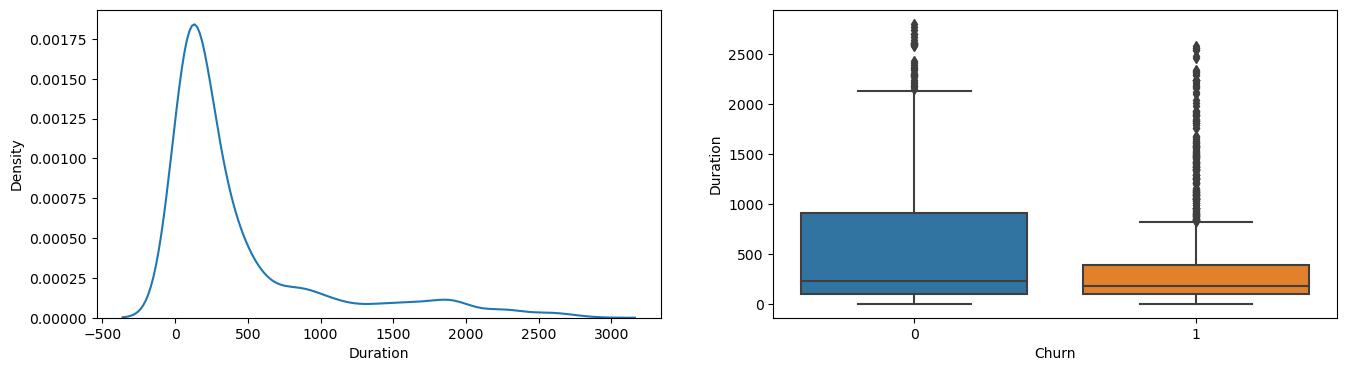

Churn
0    228.0
1    176.0
Name: Duration, dtype: float64

In [45]:
# Lets look at the distribution of "Duration" and the distribution of "Duration" with respect to "Churn" categories.

plt.figure(figsize=(16,4))

plt.subplot(1, 2, 1)
sns.kdeplot(data=dataset,x='Duration')

plt.subplot(1, 2, 2)
sns.boxplot(data=dataset,x='Churn',y='Duration')

plt.show()

dataset.groupby(by='Churn')['Duration'].median()

# The distribution is right skewed. Drivers who churn have a lower median Duration.

### 3) City

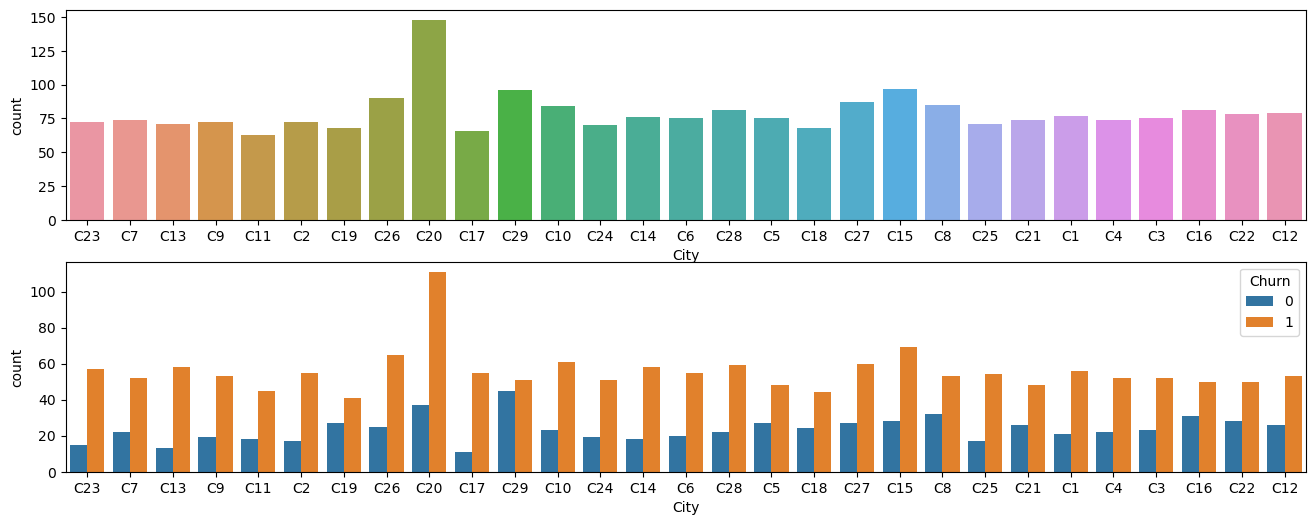

City: 29 Categories


In [46]:
# Lets look at the distribution of "City" and its distribution with respect to "Churn" categories.

plt.figure(figsize=(16,6))

plt.subplot(2, 1, 1)
sns.countplot(data=dataset,x='City',)

plt.subplot(2, 1, 2)
sns.countplot(data=dataset,x='City',hue='Churn')

plt.show()

# Lets look at the total unique number of categories for "City" Feature.
print('City:',dataset['City'].nunique(),"Categories") # There are 29 cities.

# The ratio of churn to non-churn is different across different cities. 
# We can Target-Encode this categorical column later.

### 4) Education_Level

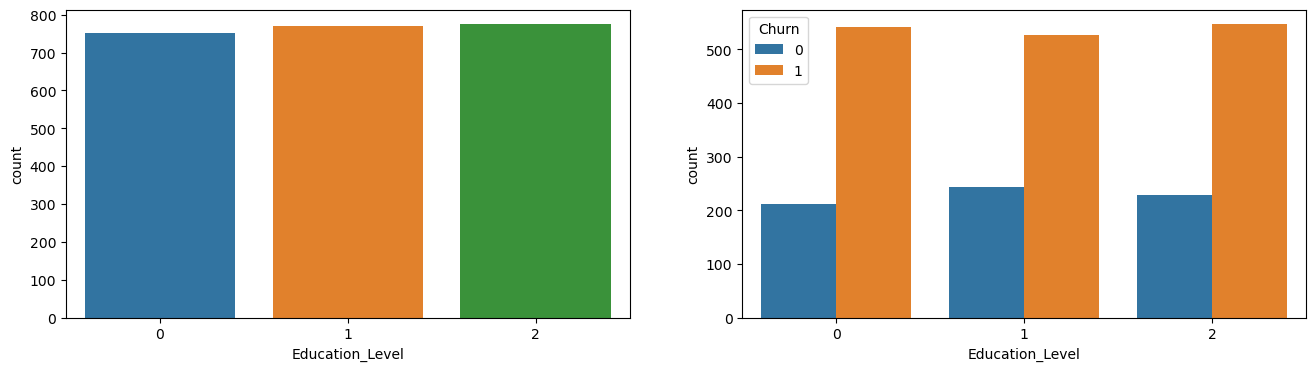

Churn,0,1
Education_Level,,
0,28.0,72.0
1,32.0,68.0
2,29.0,71.0


In [47]:
# Lets look at the distribution of "Education_Level" and its distribution with respect to "Churn" categories.

plt.figure(figsize=(16,4))

plt.subplot(1, 2, 1)
sns.countplot(data=dataset,x='Education_Level')

plt.subplot(1, 2, 2)
sns.countplot(data=dataset,x='Education_Level',hue='Churn')

plt.show()

np.round(100*pd.crosstab(dataset['Education_Level'],dataset['Churn'],normalize='index'))

# The percentage of the different categories of "Education_Level" appearing are almost same.
# The ratio of churn to non-churn is almost same across different Education Levels.

### 5) Income

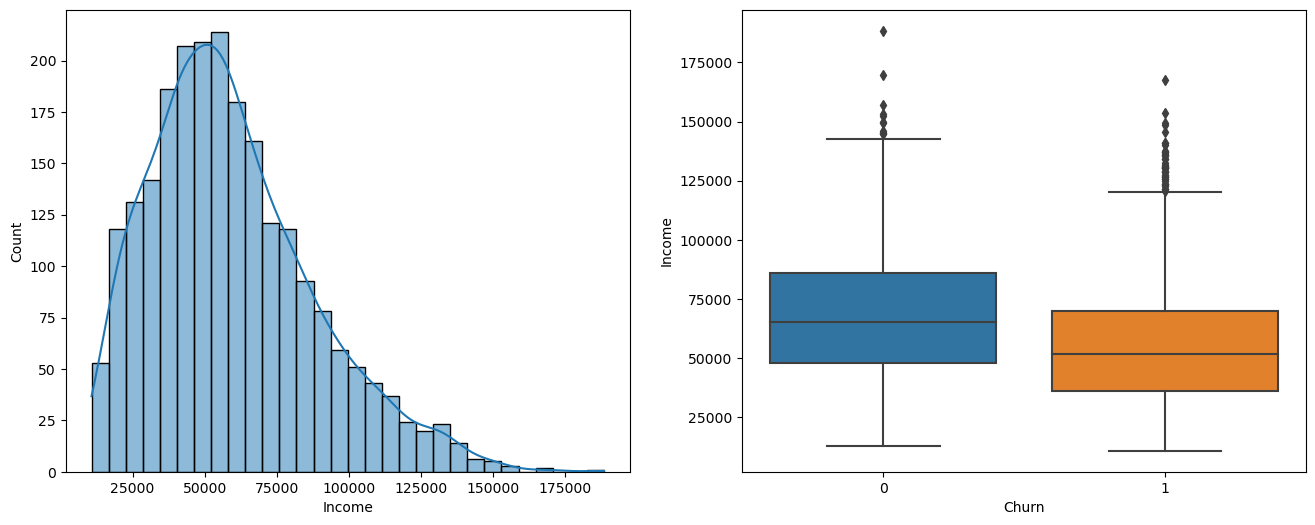

In [48]:
# Lets look at the distribution of "Income" and the distribution of "Income" with respect to "Churn" categories.

plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
sns.histplot(data=dataset,x='Income',bins=30,kde=True)

plt.subplot(1, 2, 2)
sns.boxplot(data=dataset,y='Income',x='Churn')

plt.show()

# The distribution is little right skewed. The drivers who have churned have lower median incomes.

### 6) Income_Flag

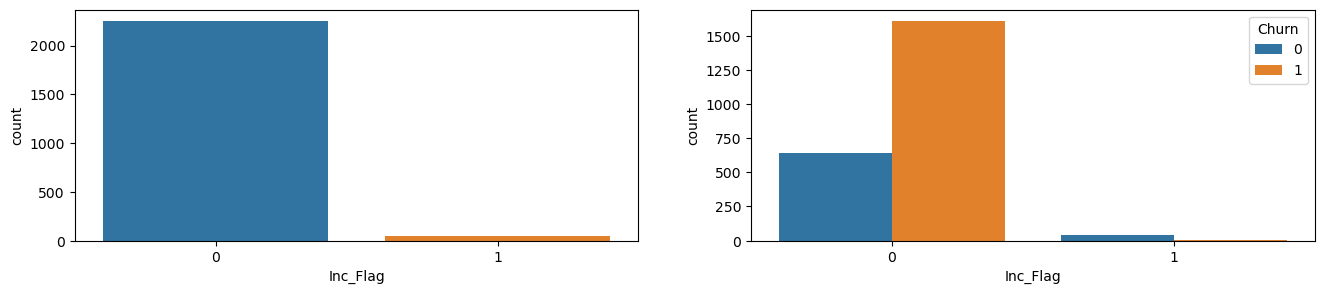

0    98.0
1     2.0
Name: Inc_Flag, dtype: float64

Churn,0,1
Inc_Flag,,
0,29.0,71.0
1,93.0,7.0


In [49]:
# Lets look at the distribution of "Income_Flag" and its distribution with respect to "Churn" categories.
# Income Flag-1 signifies that the income of a particular driver has increased over time.

plt.figure(figsize=(16,3))

plt.subplot(1, 2, 1)
sns.countplot(data=dataset,x='Inc_Flag')

plt.subplot(1, 2, 2)
sns.countplot(data=dataset,hue='Churn',x='Inc_Flag')

plt.show()

display(np.round(dataset['Inc_Flag'].value_counts(normalize=True)*100))
display(np.round(100*pd.crosstab(dataset['Inc_Flag'],dataset['Churn'],normalize='index')))

# For very few drivers, the income has increased. Drivers whose income has increased are far less likely to churn.

### 7) Age

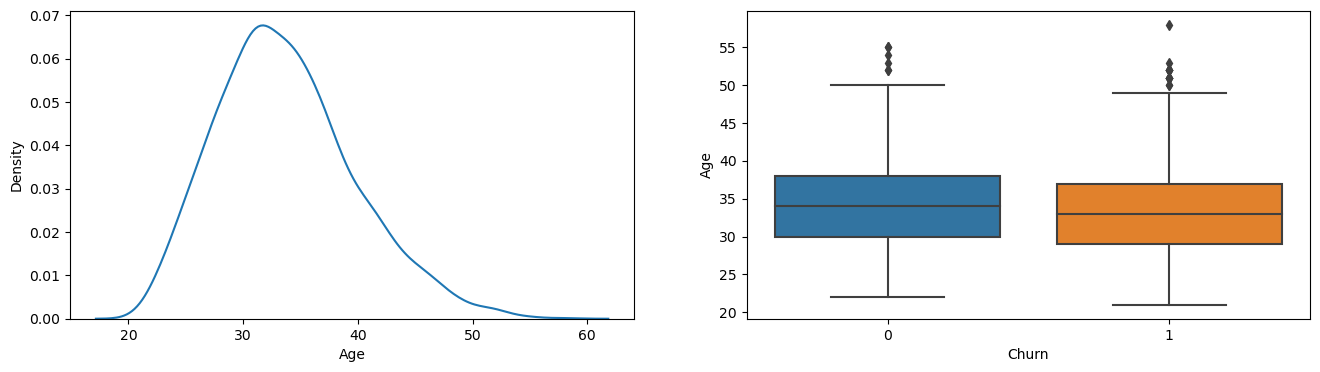

In [50]:
# Lets look at the distribution of "Age" and the distribution of "Age" with respect to "Churn" categories.

plt.figure(figsize=(16,4))

plt.subplot(1, 2, 1)
sns.kdeplot(data=dataset,x='Age')

plt.subplot(1, 2, 2)
sns.boxplot(data=dataset,x='Churn',y='Age')

plt.show()

# The distribution is little right skewed. Drivers who churn have a lower median Age.

### 8) Gender

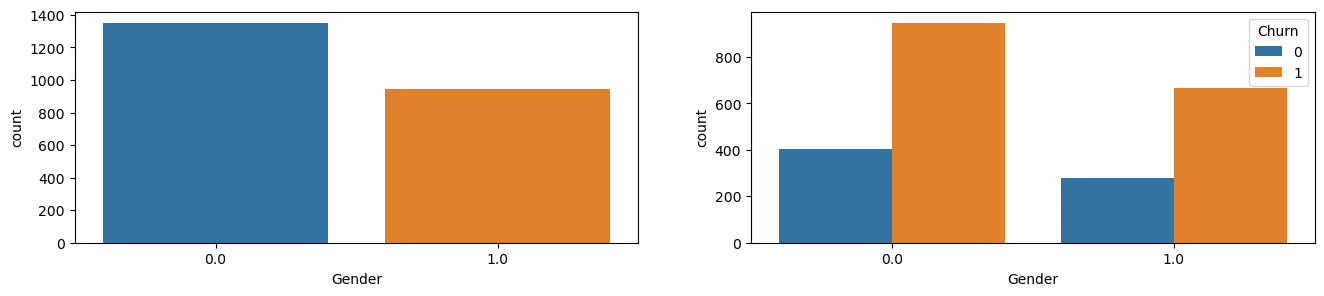

0.0    59.0
1.0    41.0
Name: Gender, dtype: float64

Churn,0,1
Gender,,
0.0,30.0,70.0
1.0,29.0,71.0


In [51]:
# Lets look at the distribution of "Gender" and its distribution with respect to "Churn" categories.
# Gender-1 signifies that the driver is a female.

plt.figure(figsize=(16,3))

plt.subplot(1, 2, 1)
sns.countplot(data=dataset,x='Gender')

plt.subplot(1, 2, 2)
sns.countplot(data=dataset,hue='Churn',x='Gender')

plt.show()

display(np.round(dataset['Gender'].value_counts(normalize=True)*100))
display(np.round(100*pd.crosstab(dataset['Gender'],dataset['Churn'],normalize='index')))

# The ratio of churn to non-churn is almost same for different Genders.

### 9) Joining Designation

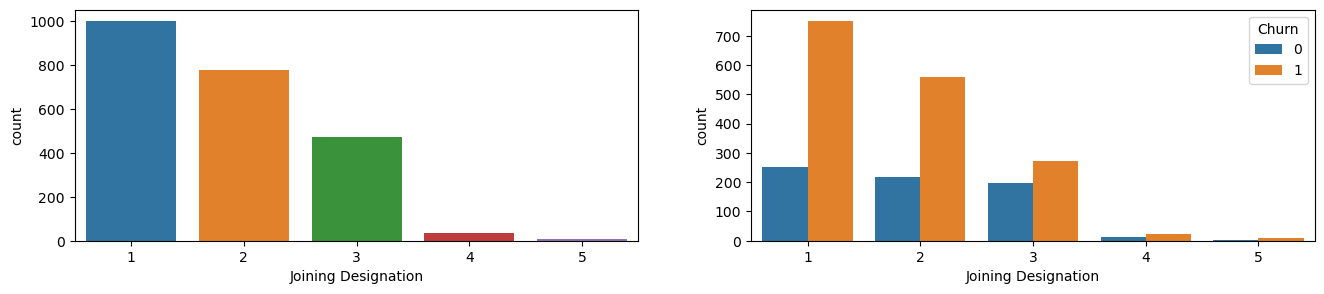

1    43.6
2    33.9
3    20.5
4     1.5
5     0.4
Name: Joining Designation, dtype: float64

Churn,0,1
Joining Designation,,
1,25.0,75.0
2,28.0,72.0
3,42.0,58.0
4,37.0,63.0
5,20.0,80.0


In [52]:
# Lets look at the distribution of "Joining Designation" and its distribution with respect to "Churn" categories.

plt.figure(figsize=(16,3))

plt.subplot(1, 2, 1)
sns.countplot(data=dataset,x='Joining Designation')

plt.subplot(1, 2, 2)
sns.countplot(data=dataset,hue='Churn',x='Joining Designation')

plt.show()

display(np.round(dataset['Joining Designation'].value_counts(normalize=True)*100,1))
display(np.round(100*pd.crosstab(dataset['Joining Designation'],dataset['Churn'],normalize='index')))

# The ratio of churn to non-churn is different for different Joining Designations.

### 10) Grade

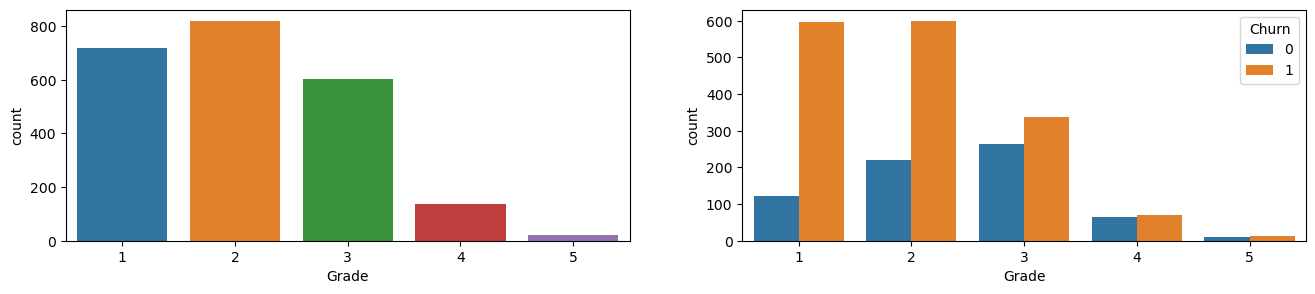

2    35.7
1    31.3
3    26.1
4     5.9
5     1.0
Name: Grade, dtype: float64

Churn,0,1
Grade,,
1,17.0,83.0
2,27.0,73.0
3,44.0,56.0
4,49.0,51.0
5,43.0,57.0


In [53]:
# Lets look at the distribution of "Grade" and its distribution with respect to "Churn" categories.

plt.figure(figsize=(16,3))

plt.subplot(1, 2, 1)
sns.countplot(data=dataset,x='Grade')

plt.subplot(1, 2, 2)
sns.countplot(data=dataset,hue='Churn',x='Grade')

plt.show()

display(np.round(dataset['Grade'].value_counts(normalize=True)*100,1))
display(np.round(100*pd.crosstab(dataset['Grade'],dataset['Churn'],normalize='index')))

# The ratio of churn to non-churn is different for different Grades.

### 11) Quarterly_Rating_Flag

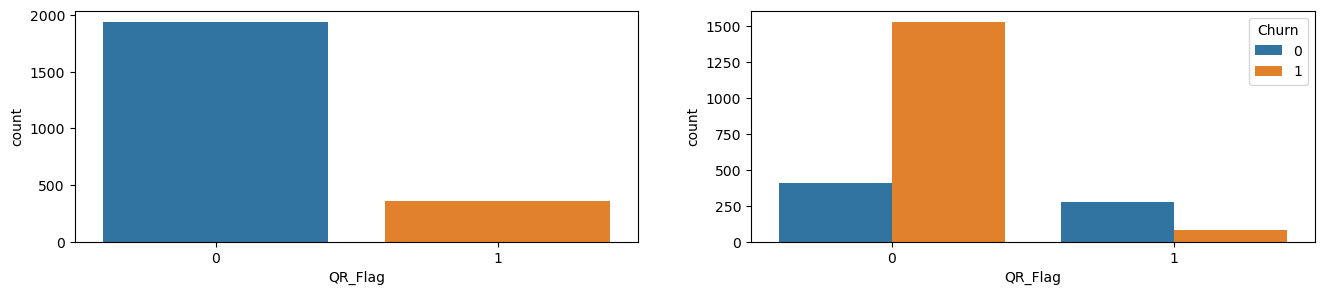

0    84.0
1    16.0
Name: QR_Flag, dtype: float64

Churn,0,1
QR_Flag,,
0,21.0,79.0
1,77.0,23.0


In [54]:
# Lets look at the distribution of "QR_Flag" and its distribution with respect to "Churn" categories.
# QR_Flag-1 signifies that the Quarterly_Rating of a particular driver has increased over time.

plt.figure(figsize=(16,3))

plt.subplot(1, 2, 1)
sns.countplot(data=dataset,x='QR_Flag')

plt.subplot(1, 2, 2)
sns.countplot(data=dataset,hue='Churn',x='QR_Flag')

plt.show()

display(np.round(dataset['QR_Flag'].value_counts(normalize=True)*100))
display(np.round(100*pd.crosstab(dataset['QR_Flag'],dataset['Churn'],normalize='index')))

# For very few drivers, the Quarterly_Rating has increased. 
# Drivers whose Quarterly_Rating has increased are far less likely to churn.

### 12) Quarterly Rating

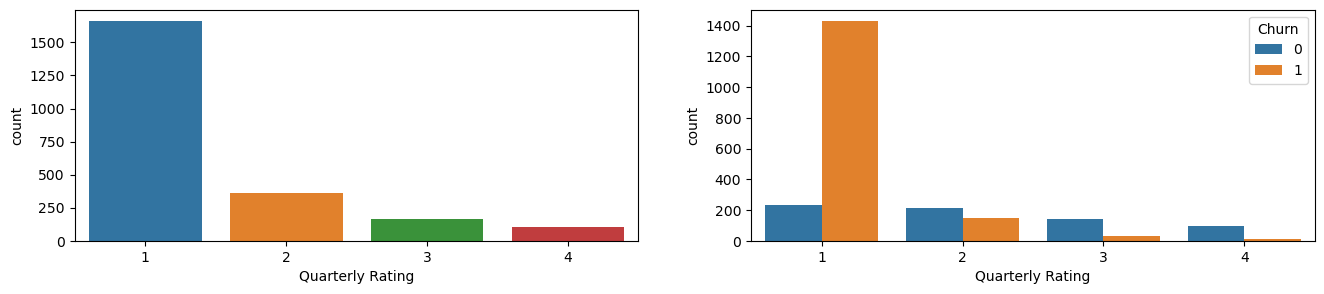

1    72.4
2    15.7
3     7.3
4     4.7
Name: Quarterly Rating, dtype: float64

Churn,0,1
Quarterly Rating,,
1,14.0,86.0
2,60.0,40.0
3,83.0,17.0
4,91.0,9.0


In [55]:
# Lets look at the distribution of "Quarterly Rating" and its distribution with respect to "Churn" categories.

plt.figure(figsize=(16,3))

plt.subplot(1, 2, 1)
sns.countplot(data=dataset,x='Quarterly Rating')

plt.subplot(1, 2, 2)
sns.countplot(data=dataset,hue='Churn',x='Quarterly Rating')

plt.show()

display(np.round(dataset['Quarterly Rating'].value_counts(normalize=True)*100,1))
display(np.round(100*pd.crosstab(dataset['Quarterly Rating'],dataset['Churn'],normalize='index')))

# The ratio of churn to non-churn is different for different Quarterly Ratings.

### 13) Total Business Value

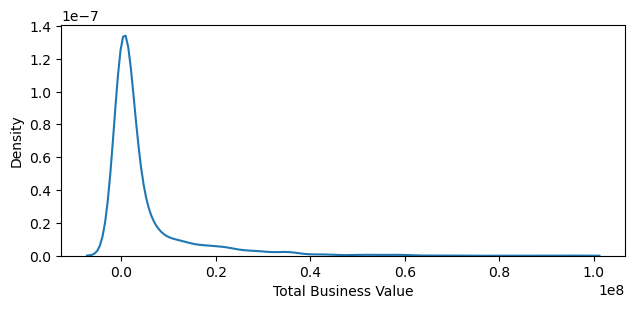

In [56]:
# Lets look at the distribution of "Total Business Value" and its distribution with respect to "Churn" categories.

plt.figure(figsize=(16,3))

plt.subplot(1, 2, 1)
sns.kdeplot(data=dataset,x='Total Business Value')

plt.show()

# The data is highly right skewed. There are a lot of large outliers.
# Lets visualize the data by considering "Total Business Value" less than 40,00,000.

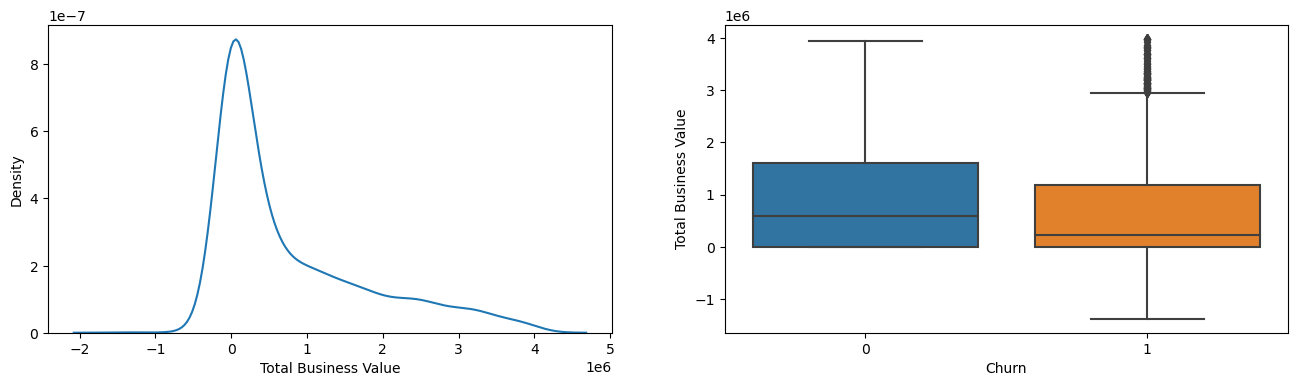

Churn
0    593300.0
1    213310.0
Name: Total Business Value, dtype: float64

In [57]:
plt.figure(figsize=(16,4))

plt.subplot(1, 2, 1)
sns.kdeplot(data=dataset[dataset['Total Business Value']<4000000],x='Total Business Value')

plt.subplot(1, 2, 2)
sns.boxplot(data=dataset[dataset['Total Business Value']<4000000],x='Churn',y='Total Business Value')

plt.show()

# Getting the median "Total Business Value" for Churned and Not-Churned Drivers.

temp = dataset[dataset['Total Business Value']<4000000]
temp.groupby(by='Churn')['Total Business Value'].median()

# Drivers who churn have a lower "Total Business Value".

## Final Dataset

In [58]:
# Removing Columns - "Driver_ID", "Dateofjoining" and "LastWorkingDate".

dataset.drop(columns=["Driver_ID", "Dateofjoining", "Last_Date"],inplace=True)

In [59]:
#Checking the shape of the dataset
print('Shape:',dataset.shape)

# We have our final dataset, which can be used for model building.
dataset.head()

Shape: (2299, 13)


,Churn,City,Education_Level,Income,Age,Gender,Joining Designation,Grade,Total Business Value,Quarterly Rating,Inc_Flag,QR_Flag,Duration
0,1,C23,2,57387,28.0,0.0,1,1,1715580,2,0,0,77
1,0,C7,2,67016,31.0,0.0,2,2,0,1,0,0,25
2,1,C13,2,65603,43.0,0.0,2,2,350000,1,0,0,142
3,1,C9,0,46368,29.0,0.0,1,1,120360,1,0,0,57
4,0,C11,1,78728,31.0,1.0,3,3,1265000,2,0,1,123


## Splitting The Data

In [60]:
# Splitting the dataset into train and test datasets.

dataset_train,dataset_test = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset['Churn'])

# Resetting the indexes.

_=dataset_train.reset_index(drop=True,inplace=True)
_=dataset_test.reset_index(drop=True,inplace=True)

In [61]:
from sklearn.covariance import EllipticEnvelope


## Outlier Removal

### 1) Elliptic Envelope

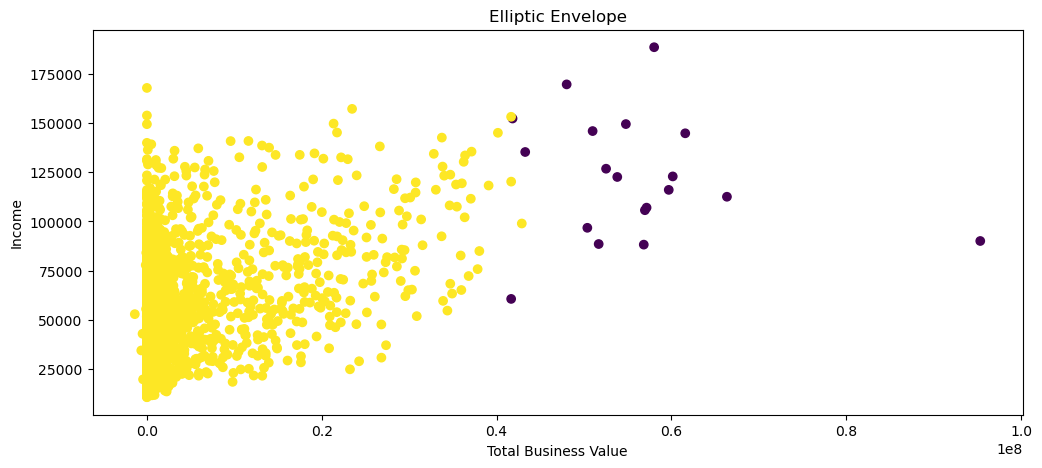

In [62]:
ee_label = EllipticEnvelope(random_state=0,contamination=0.01).fit_predict(dataset_train.drop(columns=['City']))
ee_label = pd.Series(ee_label)

plt.figure(figsize=(12,5))
plt.scatter(dataset_train['Total Business Value'],dataset_train['Income'],c=ee_label)
plt.xlabel('Total Business Value')
plt.ylabel('Income')
plt.title('Elliptic Envelope')
plt.show()

In [63]:
from sklearn.ensemble import IsolationForest

### 2) Isolation Forest

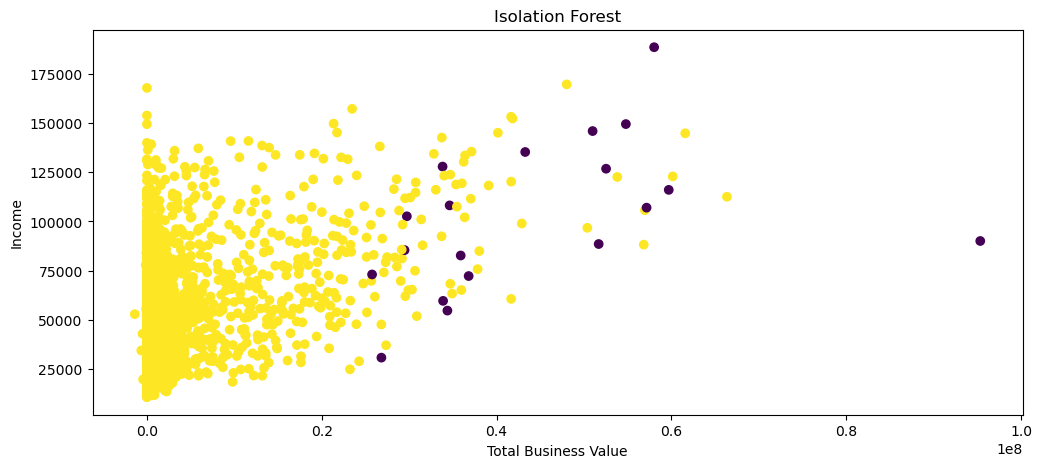

In [64]:
if_label=IsolationForest(contamination=0.01,random_state=0,n_estimators=1000).fit_predict(dataset_train.drop(columns=['City']))
if_label = pd.Series(if_label)

plt.figure(figsize=(12,5))
plt.scatter(dataset_train['Total Business Value'],dataset_train['Income'],c=if_label)
plt.xlabel('Total Business Value')
plt.ylabel('Income')
plt.title('Isolation Forest')
plt.show()

In [65]:
from sklearn.neighbors import LocalOutlierFactor

### 3) Local Outlier Factor

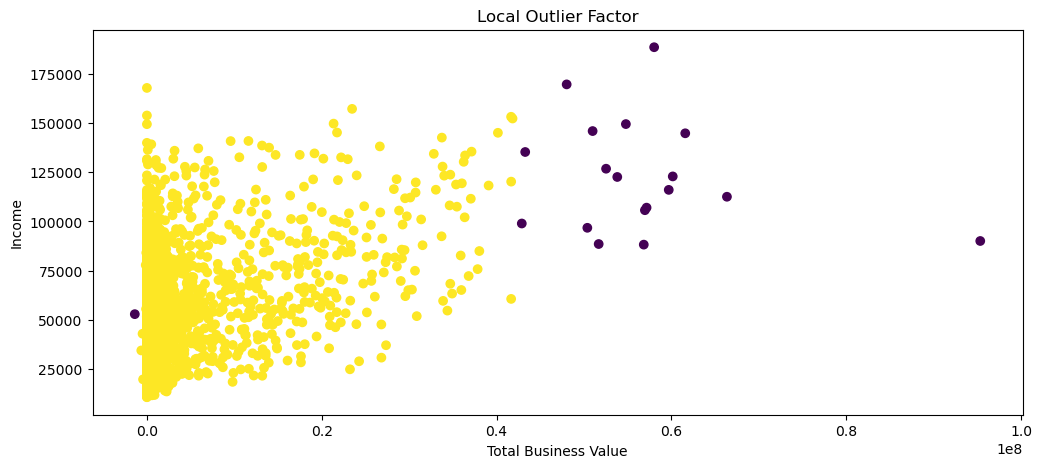

In [66]:
lof_label = LocalOutlierFactor(n_neighbors=600,contamination=0.01).fit_predict(dataset_train.drop(columns=['City']))
lof_label = pd.Series(lof_label)

plt.figure(figsize=(12,5))
plt.scatter(dataset_train['Total Business Value'],dataset_train['Income'],c=lof_label)
plt.xlabel('Total Business Value')
plt.ylabel('Income')
plt.title('Local Outlier Factor')
plt.show()

- Out of the 3 outlier detection algorithms, "Local Outlier Factor" seems to work the best.
- Going ahead with "Local Outlier Factor" to remove the outliers.

In [67]:
# Removing the outliers.

dataset_train = dataset_train[lof_label==1].reset_index(drop=True)

print("Train",dataset_train.shape)
print("Test",dataset_test.shape)

Train (1820, 13)
Test (460, 13)


## Target Encoding
- Need to encode "City" feature.

In [68]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [69]:
pip install Numpy==1.23.5

  Using cached numpy-1.23.5-cp39-cp39-win_amd64.whl (14.7 MB)
  Attempting uninstall: Numpy
    Found existing installation: numpy 1.26.0
    Uninstalling numpy-1.26.0:
      Successfully uninstalled numpy-1.26.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
datasets 2.14.4 requires huggingface-hub<1.0.0,>=0.14.0, but you have huggingface-hub 0.11.1 which is incompatible.
pandas-profiling 3.1.0 requires joblib~=1.0.1, but you have joblib 1.2.0 which is incompatible.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 1.1.1 which is incompatible.
streamlit 1.12.0 requires protobuf<4,>=3.12, but you have protobuf 4.24.3 which is incompatible.
tensorboard 2.11.0 requires protobuf<4,>=3.9.2, but you have protobuf 4.24.3 which is incompatible.
tensorflow-intel 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.24.3 which is incompatible.


In [70]:
from category_encoders import TargetEncoder

In [71]:
# Creating a Target Encoder object.

t_enc = TargetEncoder()

# Getting the Target Encodings for "City" for both train and test data.

dataset_train['City'] = t_enc.fit_transform(dataset_train['City'],dataset_train['Churn'])
dataset_test['City'] = t_enc.transform(dataset_test['City'])

## Scaling

In [72]:
# Creating a Standard-Scaler object.

scaler = StandardScaler()

# Scaling all the continuous features in both train and test data.

dataset_train[continuous] = scaler.fit_transform(dataset_train[continuous])
dataset_test[continuous] = scaler.transform(dataset_test[continuous])

## Splitting into X and Y

In [73]:
# Splitting both train data and test data into X and Y.

X_train,y_train = dataset_train.drop(columns=['Churn']),dataset_train['Churn']
X_test,y_test = dataset_test.drop(columns=['Churn']),dataset_test['Churn']

## Defining Classification Metrics

In [74]:
# Defining a function for various classification metrics.

def metrics(model):
    
    # Getting the F1-Score of best Model.
    score = round(model.best_score_,3)
    
    # Getting the hyperparameters of best Model.
    max_depth = model.best_params_['max_depth'] 
    n_est = model.best_params_['n_estimators']
    
    return [max_depth,n_est,score]


# Creating a list to store the metrics.
results=[]

## Model 1 - Random Forests

In [75]:
# Creating a parameters_list to do Hyperparameter Tuning.

parameters = {'n_estimators': [80,90,100,110,120,130],
                'max_depth':[16,20,24,28,32]}

# Creating a Grid_Search Object
model_rf = GridSearchCV(RandomForestClassifier(random_state=42),parameters,scoring='f1',cv=3)

# Fitting the training data.
model_rf.fit(X_train,y_train)

# Getting the Classification metrics.
results.append(['Random Forest'] + metrics(model_rf))

## Model 2 - XGBoost

In [76]:
# Creating a parameters_list to do Hyperparameter Tuning

parameters = {'n_estimators': [15,20,25,30,35,40,45,50],
                'max_depth':[9,10,11,12,13,14],
                'learning_rate':[0.5,0.75,1]}

# Creating a Grid_Search Object
model_xg = GridSearchCV(XGBClassifier(random_state=42),parameters,scoring='f1',cv=3)

# Fitting the training data.
model_xg.fit(X_train,y_train)

# Getting the Classification metrics.
results.append(['XGBoost'] + metrics(model_xg)) 

## Handling Imbalanced Data using SMOTE

In [77]:
# Getting Balanced Data using SMOTE.

from imblearn.over_sampling import SMOTENC

smote_model = SMOTENC(categorical_features=[0,1,4,5,6,8,9,10],sampling_strategy='minority',random_state=42)
X_train_SMOTE,y_train_SMOTE = smote_model.fit_resample(X_train,y_train)

## Model 3 - Random Forests with SMOTE

In [78]:
# Creating a parameters_list to do Hyperparameter Tuning.

parameters = {'n_estimators': [80,90,100,110,120,130],
                'max_depth':[16,20,24,28,32]}

# Creating a Grid_Search Object
model_rf_s = GridSearchCV(RandomForestClassifier(random_state=42),parameters,scoring='f1',cv=3)

# Fitting the training data.
model_rf_s.fit(X_train_SMOTE,y_train_SMOTE)

# Getting the Classification metrics.
results.append(['Random Forest + SMOTE'] + metrics(model_rf_s))

## Model 4 - XGBoost with SMOTE

In [79]:
# Creating a parameters_list to do Hyperparameter Tuning

parameters = {'n_estimators': [15,20,25,30,35,40,45,50],
                'max_depth':[9,10,11,12,13,14],
                'learning_rate':[0.5,0.75,1]}

# Creating a Grid_Search Object
model_xg_s = GridSearchCV(XGBClassifier(random_state=42),parameters,scoring='f1',cv=3)

# Fitting the training data.
model_xg_s.fit(X_train_SMOTE,y_train_SMOTE)

# Getting the Classification metrics.
results.append(['XGBoost + SMOTE'] + metrics(model_xg_s))

## Model Comparison

In [80]:
# Creating a DataFrame to store the results.

results_df = pd.DataFrame(data=results, columns=['Model','Max_Depth','N_Estimators','F1-Score'])
display(results_df)

,Model,Max_Depth,N_Estimators,F1-Score
0,Random Forest,24,130,0.904
1,XGBoost,11,30,0.900
2,Random Forest + SMOTE,24,120,0.882
3,XGBoost + SMOTE,11,35,0.880


- Since the Random Forests model has a better F1 validation score, we can therefore use this as our final model and determine the unbiased test_set performance.

## Test Data Performance

In [81]:
# Getting the Performance on the test data.

y_pred = model_rf.predict(X_test)
y_pred_prob = model_rf.predict_proba(X_test)

# Getting the Classification metrics.

accuracy = round(accuracy_score(y_test,y_pred),2) 
recall = round(recall_score(y_test,y_pred),2)
precision = round(precision_score(y_test,y_pred),2)
f1 = round(f1_score(y_test,y_pred),2)

# ROC_AUC Score
roc_score = round(roc_auc_score(y_test, y_pred_prob[:,1]),2)

# AU-PRC
precision_,recall_,thresholds = precision_recall_curve(y_test, y_pred_prob[:,1])
prc_score = round(auc(recall_, precision_),2)

metrics = [[accuracy,precision,recall,f1,roc_score,prc_score]]

# Creating a DataFrame to store the results.

metrics_df = pd.DataFrame(data=metrics, columns=['accuracy','Precision','Recall','F1','ROC_Score','PRC_Score'])
display(metrics_df)

,accuracy,Precision,Recall,F1,ROC_Score,PRC_Score
0,0.84,0.86,0.93,0.89,0.89,0.94


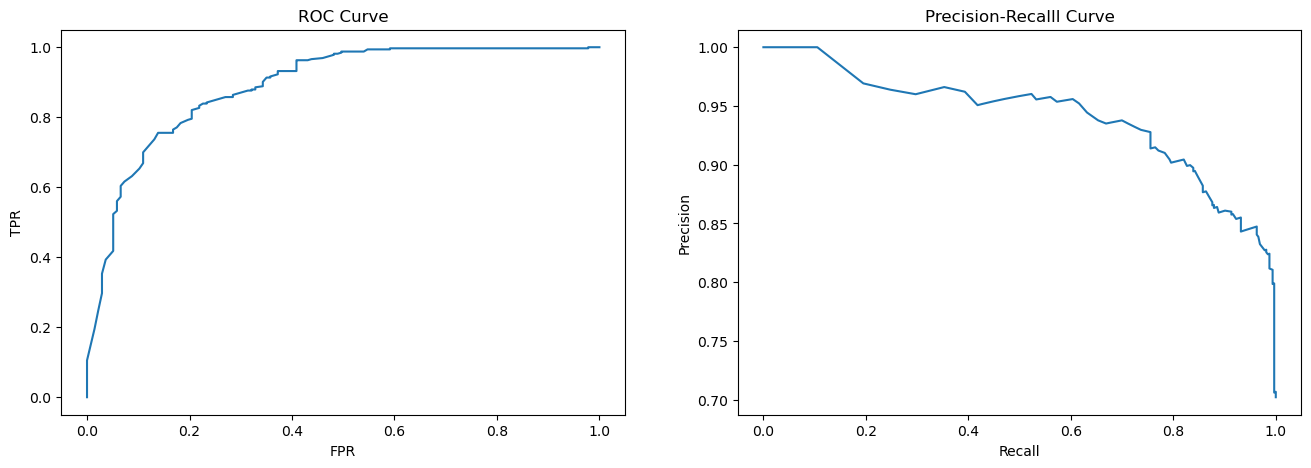

In [82]:
# Plotting ROC Curve and Precision-Recalll Curve.

plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
fpr,tpr,thresholds = roc_curve(y_test, y_pred_prob[:,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

plt.subplot(1, 2, 2)
precision,recall,thresholds = precision_recall_curve(y_test, y_pred_prob[:,1])
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recalll Curve')

plt.show()

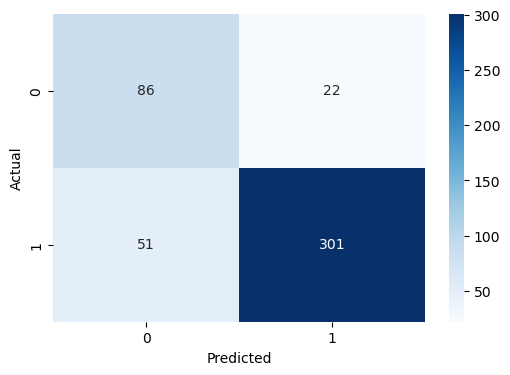

In [83]:
# Confusion Matrix

plt.figure(figsize=(6,4))

sns.heatmap(pd.crosstab(y_pred,y_test),annot=True,fmt='g',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel("Actual")

plt.show()

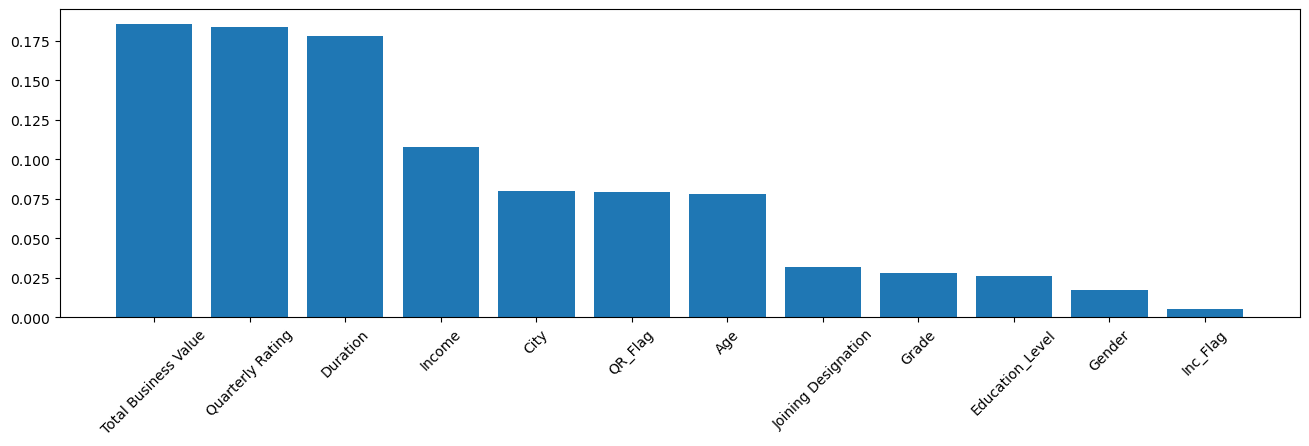

In [84]:
# Getting the feature importances and plotting them.

feature_importance = pd.Series(index=model_rf.feature_names_in_, data = model_rf.best_estimator_.feature_importances_)
feature_importance.sort_values(ascending=False,inplace=True)

plt.figure(figsize=(16,4))
plt.bar(x=feature_importance.index,height=feature_importance.values)
plt.xticks(rotation=45)
plt.show()

# Insights
- Our best model has Precision: 0.86, Recall: 0.93 and F1-Score: 0.89, which are good scores for a classification model.
- ROC_Score of 0.89 and PRC_Score of 0.94 are good scores for our model.
- The number of FNs are more than FPs. By decreasing the threshold we can try to reduce the FNs.
- If we need to identify drivers who are likely to churn, we should try to maximize Recall. By doing so we can get most of the drivers who are probably going to churn.
- "Total Business Value", "Quarterly Rating" and "Duration" are the most important predictors of Churn.
- "Education Level", "Gender" and "Income Flag" are the least important predictors of Churn.

# Creating Pipeline

- **"Column_Transformer"** : It allows different columns to be transformed separately and the output generated by each column tranformation will be concatenated to form a single feature space.
- **"Pipeline"** : Sequentially apply a list of transformers and a final estimator.

In [85]:
# Getting X and Y from the dataset.

X = dataset.drop(columns=['Churn'])
y = dataset['Churn']

In [86]:
# Building a transformer which does Scaling and Target-Encoding.

transformer = ColumnTransformer(transformers=[
        ('scaling',StandardScaler(),continuous),
        ('target_encoding',TargetEncoder(),['City'])
        ],
        remainder="passthrough")

model = Pipeline([
    ('transformer',transformer),
    ('ml_model',RandomForestClassifier(n_estimators=130,max_depth=24))
    ])

# Fitting the model.
model.fit(X,y)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', StandardScaler(),
                                                  ['Income', 'Age',
                                                   'Total Business Value',
                                                   'Duration']),
                                                 ('target_encoding',
                                                  TargetEncoder(),
                                                  ['City'])])),
                ('ml_model',
                 RandomForestClassifier(max_depth=24, n_estimators=130))])

In [87]:
# Saving the model as a pickle file.

pickle.dump(model, open('classifier.pkl', 'wb'))